# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from keras.applications.densenet import DenseNet121
from keras.applications.xception import Xception
from keras.applications.densenet import preprocess_input
from keras.optimizers import Adam, SGD, Adamax
from keras.models import Model, load_model
from keras.layers import *
from sklearn.model_selection import train_test_split
from keras.callbacks import *

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras import regularizers
from keras.src import callbacks

# Train test split

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
image_size = (224, 224)
batch_size = 32

In [4]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/BM1000",
    validation_split=0.25,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5850 files belonging to 7 classes.
Using 4388 files for training.
Using 1462 files for validation.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['BAS', 'EOS', 'HAC', 'LYT', 'MON', 'NGB', 'NGS']
7


In [ ]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
#count.index
print(count)

0    331
1    745
2    316
3    735
4    745
5    765
6    751
dtype: int64


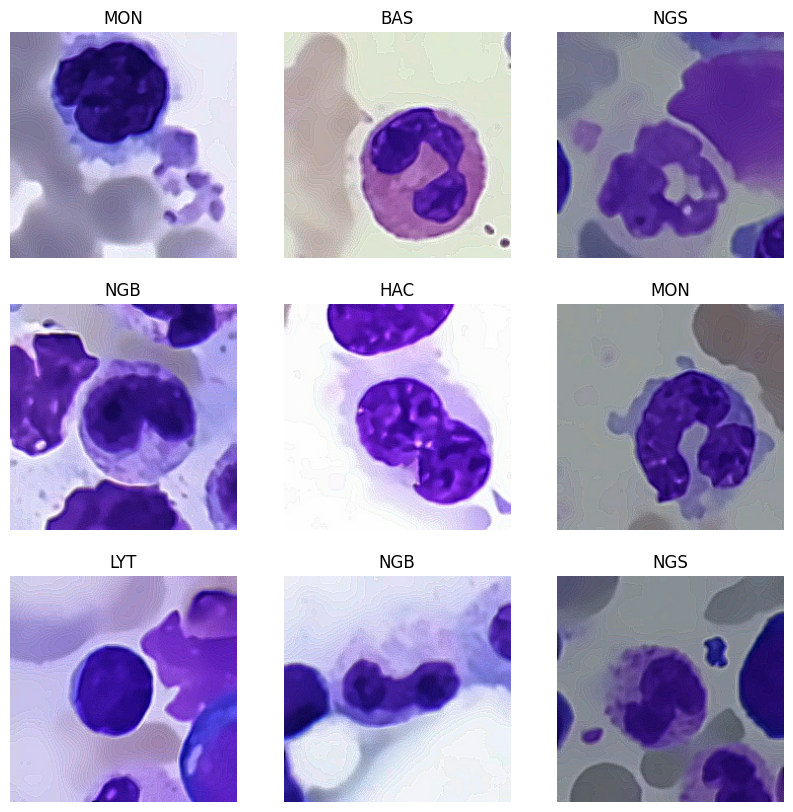

In [ ]:
#Here are the first nine images from the training dataset.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(first_image)

tf.Tensor(
[[[102.  44. 224.]
  [102.  47. 228.]
  [ 95.  41. 225.]
  ...
  [189. 179. 239.]
  [199. 188. 246.]
  [197. 186. 244.]]

 [[105.  47. 227.]
  [102.  47. 228.]
  [ 94.  40. 222.]
  ...
  [187. 177. 237.]
  [193. 183. 243.]
  [191. 181. 241.]]

 [[103.  45. 227.]
  [101.  46. 227.]
  [ 96.  43. 223.]
  ...
  [199. 190. 253.]
  [206. 197. 255.]
  [205. 196. 255.]]

 ...

 [[220. 214. 252.]
  [219. 213. 251.]
  [221. 213. 254.]
  ...
  [208. 196. 246.]
  [204. 191. 244.]
  [206. 193. 247.]]

 [[221. 217. 254.]
  [218. 212. 250.]
  [221. 213. 252.]
  ...
  [195. 183. 231.]
  [205. 191. 242.]
  [206. 189. 241.]]

 [[217. 213. 250.]
  [220. 216. 253.]
  [220. 212. 251.]
  ...
  [202. 190. 236.]
  [205. 189. 238.]
  [228. 210. 255.]]], shape=(224, 224, 3), dtype=float32)


# Data Augmentation

In [6]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
  ]
)

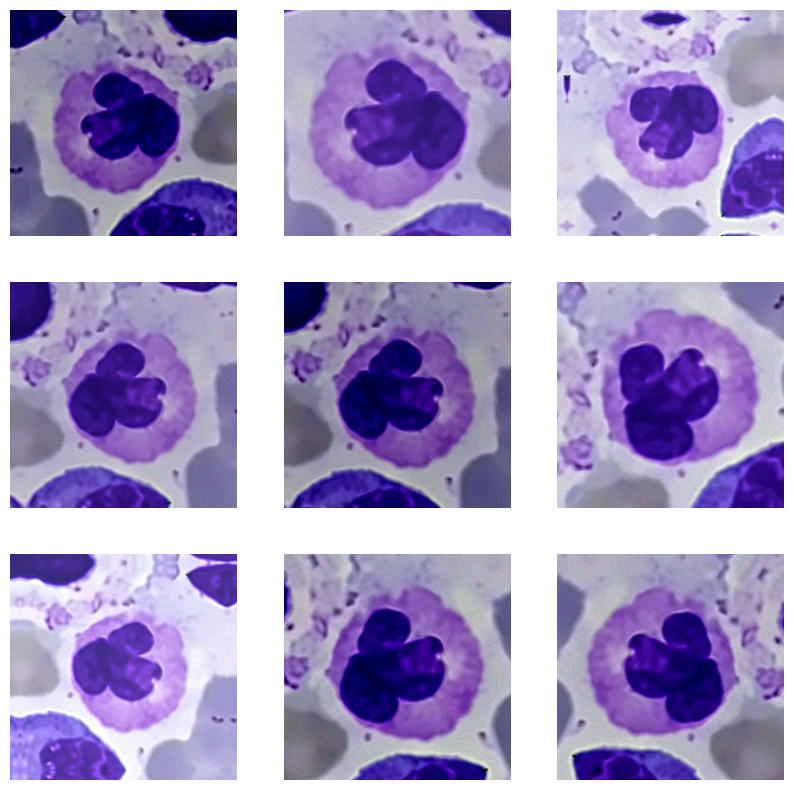

In [ ]:
#Visualize a few augmented examples by applying data augmentation to the same image several times:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [7]:
train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch overlaps data preprocessing and model execution while training.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Early Stopping

In [9]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Sequential Model 1

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(l=0.01)),
  layers.Dense(7, activation='softmax', name="outputs")
])

In [ ]:
model.compile(Adamax(learning_rate= 0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)       

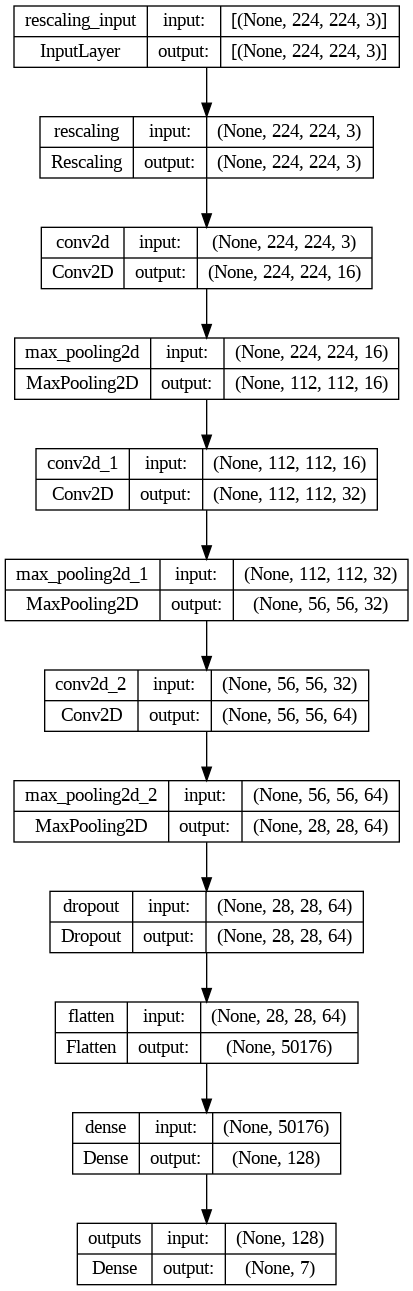

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 70
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=256,
  callbacks=[early_stopping]
)

Epoch 1/70
138/138 [==============================] - 95s 216ms/step - loss: 3.0430 - accuracy: 0.2359 - val_loss: 2.4720 - val_accuracy: 0.3495
Epoch 2/70
138/138 [==============================] - 6s 45ms/step - loss: 2.3499 - accuracy: 0.3336 - val_loss: 2.1710 - val_accuracy: 0.4001
Epoch 3/70
138/138 [==============================] - 6s 45ms/step - loss: 2.1544 - accuracy: 0.3546 - val_loss: 2.0539 - val_accuracy: 0.4049
Epoch 4/70
138/138 [==============================] - 6s 46ms/step - loss: 2.0373 - accuracy: 0.3751 - val_loss: 2.0113 - val_accuracy: 0.3495
Epoch 5/70
138/138 [==============================] - 6s 45ms/step - loss: 1.9520 - accuracy: 0.3838 - val_loss: 1.8541 - val_accuracy: 0.4220
Epoch 6/70
138/138 [==============================] - 6s 45ms/step - loss: 1.8773 - accuracy: 0.3906 - val_loss: 1.8111 - val_accuracy: 0.4337
Epoch 7/70
138/138 [==============================] - 6s 46ms/step - loss: 1.8185 - accuracy: 0.4191 - val_loss: 1.7925 - val_accuracy: 0.41

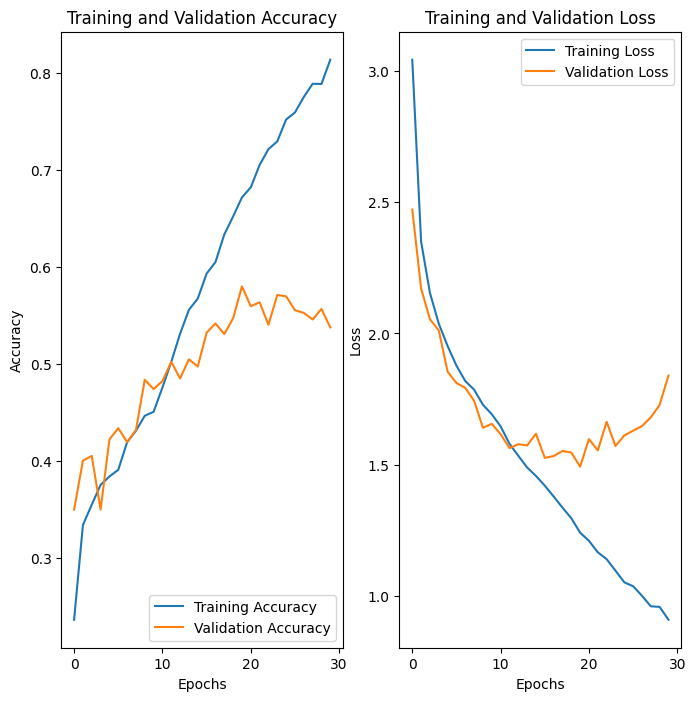

In [ ]:
#Create plots of the loss and accuracy on the training and validation sets:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_test = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy_score(y_test, y_pred_classes)

46/46 [==============================] - 1s 11ms/step


0.5800273597811217

In [ ]:
print(classification_report(y_test, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

         BAS       0.44      0.16      0.24       110
         EOS       0.60      0.67      0.63       255
         HAC       0.60      0.56      0.58        93
         LYT       0.69      0.74      0.71       265
         MON       0.53      0.63      0.57       255
         NGB       0.51      0.41      0.45       235
         NGS       0.57      0.62      0.59       249

    accuracy                           0.58      1462
   macro avg       0.56      0.54      0.54      1462
weighted avg       0.57      0.58      0.57      1462

